# Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

- Name    : Yun-Chen Wang - 9040873
- Prof    : Islam Mahmoud

**About this report**: Conduct a common practice of Deep Learning Engineers: take a model and fine-tune it.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import os, pathlib
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Obtain the Data

Get the dataset: [Dogs vs. Cats](https://www.kaggle.com/competitions/dogs-vs-cats/overview)
1. Go to `Data` page.
2. Click `agree to the agreement`
3. Click `Download all`

Extract download dataset.

In [93]:
# My unzip function
def my_unzip(input_file, output_path):
    os.makedirs(output_path, exist_ok=True)
    if os.path.exists(input_file):
        with zipfile.ZipFile(input_file, 'r') as zip_ref:
            zip_ref.extractall(output_path)
        print(f"Dataset extracted to {output_path}")
    else:
        print(f"Download failed or file not found: {input_file}")
    return

Unzip download zip file.

In [94]:
# Unzip dogs-vs-cats.zip
my_unzip(input_file="../data/dogs-vs-cats.zip", 
         output_path="../data/")

Dataset extracted to ../data/


Unzip train and test1 zip file.

In [95]:
# Unzip train.zip
my_unzip(input_file="../data/train.zip", 
         output_path="../data/kaggle_dogs_vs_cats")
# Unzip test1.zip# Load training dataset (automatically assigns labels based on subfolder names)
my_unzip(input_file="../data/test1.zip", 
         output_path="../data/kaggle_dogs_vs_cats")

Dataset extracted to ../data/kaggle_dogs_vs_cats
Dataset extracted to ../data/kaggle_dogs_vs_cats


Check how many files are there in each unzip folder.

In [96]:
output_path = '../data/kaggle_dogs_vs_cats/train'
files = os.listdir(output_path)
print(f"Total files and directories in {output_path}: {len(files)}")
print("Some files:", files[:10])

output_path = '../data/kaggle_dogs_vs_cats/test1'
files = os.listdir(output_path)
print(f"Total files and directories in {output_path}: {len(files)}")
print("Some files:", files[:10])

Total files and directories in ../data/kaggle_dogs_vs_cats/train: 25000
Some files: ['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg', 'cat.10151.jpg', 'cat.3406.jpg', 'dog.1753.jpg', 'cat.4369.jpg', 'cat.7660.jpg', 'dog.5535.jpg']
Total files and directories in ../data/kaggle_dogs_vs_cats/test1: 12500
Some files: ['9733.jpg', '63.jpg', '6400.jpg', '823.jpg', '4217.jpg', '3578.jpg', '10321.jpg', '2666.jpg', '5109.jpg', '11981.jpg']


Make subset from `../data/kaggle_dogs_vs_cats/train`.

In [ ]:
original_dir = pathlib.Path("../data/kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 2. EDA: Explore the data with relevant graphs, statistics and insights (5 points)

Check how many image files are there in each set.

In [2]:
def count_files(new_base_dir, subset_name):
    subset_dir = new_base_dir / subset_name
    counts = {}
    
    for category in ("cat", "dog"):
        category_dir = subset_dir / category
        if category_dir.exists():
            counts[category] = len(list(category_dir.glob("*.jpg")))
        else:
            counts[category] = 0
    
    return counts

new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

# Count files in each subset
train_counts = count_files(new_base_dir, "train")
validation_counts = count_files(new_base_dir, "validation")
test_counts = count_files(new_base_dir, "test")

# Print results
print("File counts in each subset:")
print(f"Train: {train_counts}")
print(f"Validation: {validation_counts}")
print(f"Test: {test_counts}")

File counts in each subset:
Train: {'cat': 1000, 'dog': 1000}
Validation: {'cat': 500, 'dog': 500}
Test: {'cat': 1000, 'dog': 1000}


Visualize the image counts of each set.

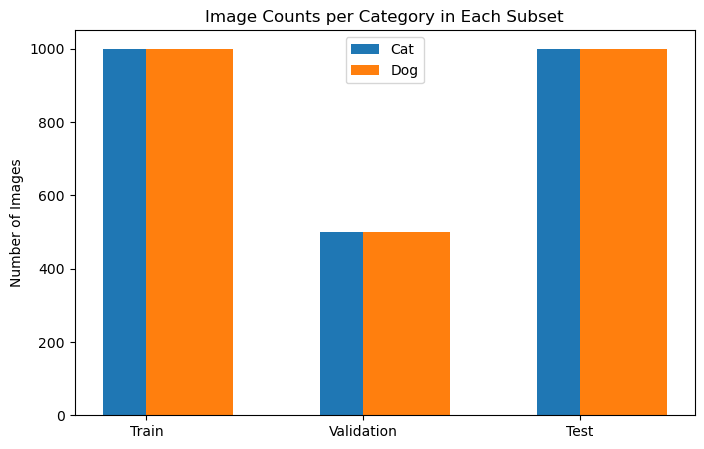

In [3]:
import matplotlib.pyplot as plt

def plot_counts(counts_dict, title):
    labels = list(counts_dict.keys())
    cat_counts = [counts_dict[k]['cat'] for k in labels]
    dog_counts = [counts_dict[k]['dog'] for k in labels]

    x = range(len(labels))
    plt.figure(figsize=(8, 5))
    plt.bar(x, cat_counts, width=0.4, label='Cat', align='center')
    plt.bar(x, dog_counts, width=0.4, label='Dog', align='edge')
    plt.xticks(x, labels)
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.legend()
    plt.show()

plot_counts({
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
}, "Image Counts per Category in Each Subset")


Analyze image sizes and store them into a new dataframe - metadata, for each training, validation and testing set.

In [4]:
from PIL import Image
import numpy as np

def describe_image_size(base_dir, subset):
    """
    1. Fetch all image sizes from dataset folder, then calculate the mean, min and max values for weight and height.
    2. For each image size: 
        Column 0 => image widths
        Column 1 => image heights
    3. For example: 
        Mean Sizes: [407.214 365.296], means that the mean of whole image weight is 407.214, the mean of whole image height is 365.296
        Min Sizes: [59 45], means that the min of whole image weight is 59, the mean of whole image height is 45
        Max Sizes: [500 500], means that the max of whole image weight is 500, the mean of whole image height is 500
    4. Axis=0:
        Calling NumPy to compute the mean along axis 0, which means:
            - Operate down the rows, across all entries in each column (Column 0 => image widths, Column 1 => image heights).
    """
    sizes = []
    data = []
    for category in ["cat", "dog"]:
        dir_path = base_dir / subset / category
        for img_name in os.listdir(dir_path):
            if img_name.lower().endswith(".jpg"):  # Only process .jpg files
                img_path = dir_path / img_name
                with Image.open(img_path) as img:
                    sizes.append(img.size)
                    width, height = img.size
                    pixels = width*height
                    data.append({
                        "filename": img_name,
                        "subset": subset,
                        "category": category,
                        "width": width,
                        "height": height,
                        "pixels": pixels
                    })
    
    
    sizes = np.array(sizes)
    print(f"Subset: {subset}, numpy shape: {sizes.shape} => {sizes.shape[0]}rows x {sizes.shape[0]}columns")
    print(f"\tMean Sizes: {sizes.mean(axis=0)}") # axis=0: Operate down the rows, across all entries in each column.
    print(f"\tMin Sizes: {sizes.min(axis=0)}")
    print(f"\tMax Sizes: {sizes.max(axis=0)}")
    return pd.DataFrame(data)

train_metadata = describe_image_size(new_base_dir, "train")
validation_metadata = describe_image_size(new_base_dir, "validation")
test_metadata = describe_image_size(new_base_dir, "test")

display(train_metadata.head())
display(validation_metadata.head())
display(test_metadata.head())

Subset: train, numpy shape: (2000, 2) => 2000rows x 2000columns
	Mean Sizes: [403.9725 358.9175]
	Min Sizes: [59 50]
	Max Sizes: [1023  768]
Subset: validation, numpy shape: (1000, 2) => 1000rows x 1000columns
	Mean Sizes: [407.214 365.296]
	Min Sizes: [59 45]
	Max Sizes: [500 500]
Subset: test, numpy shape: (2000, 2) => 2000rows x 2000columns
	Mean Sizes: [402.127 359.846]
	Min Sizes: [59 41]
	Max Sizes: [1050  702]


filename subset category  width  height  pixels
0  cat.952.jpg  train      cat    499     375  187125
1  cat.946.jpg  train      cat    500     374  187000
2    cat.6.jpg  train      cat    400     303  121200
3  cat.749.jpg  train      cat    499     340  169660
4  cat.991.jpg  train      cat    499     375  187125

filename      subset category  width  height  pixels
0  cat.1211.jpg  validation      cat    249     200   49800
1  cat.1205.jpg  validation      cat    319     297   94743
2  cat.1239.jpg  validation      cat    500     465  232500
3  cat.1013.jpg  validation      cat    500     480  240000
4  cat.1007.jpg  validation      cat    500     374  187000

filename subset category  width  height  pixels
0  cat.1577.jpg   test      cat    340     500  170000
1  cat.1563.jpg   test      cat    499     375  187125
2  cat.2042.jpg   test      cat    500     378  189000
3  cat.2056.jpg   test      cat    500     374  187000
4  cat.1588.jpg   test      cat    256     255   65280

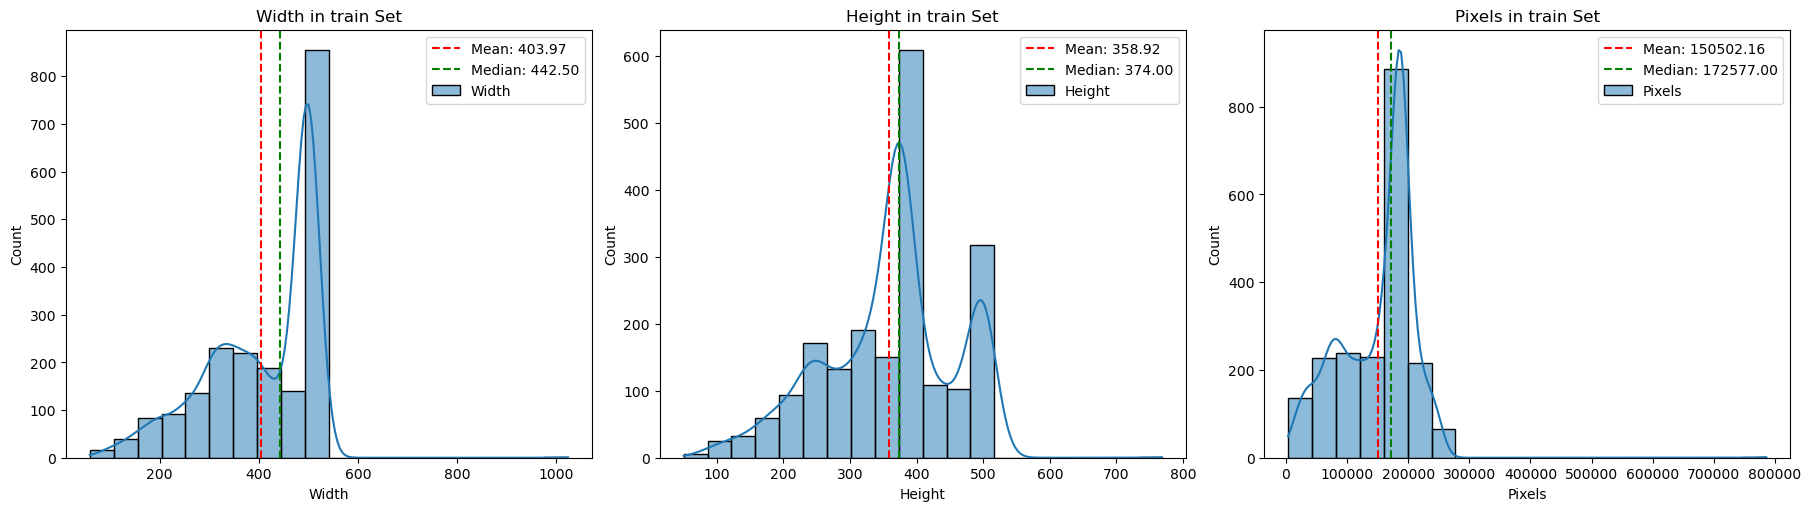

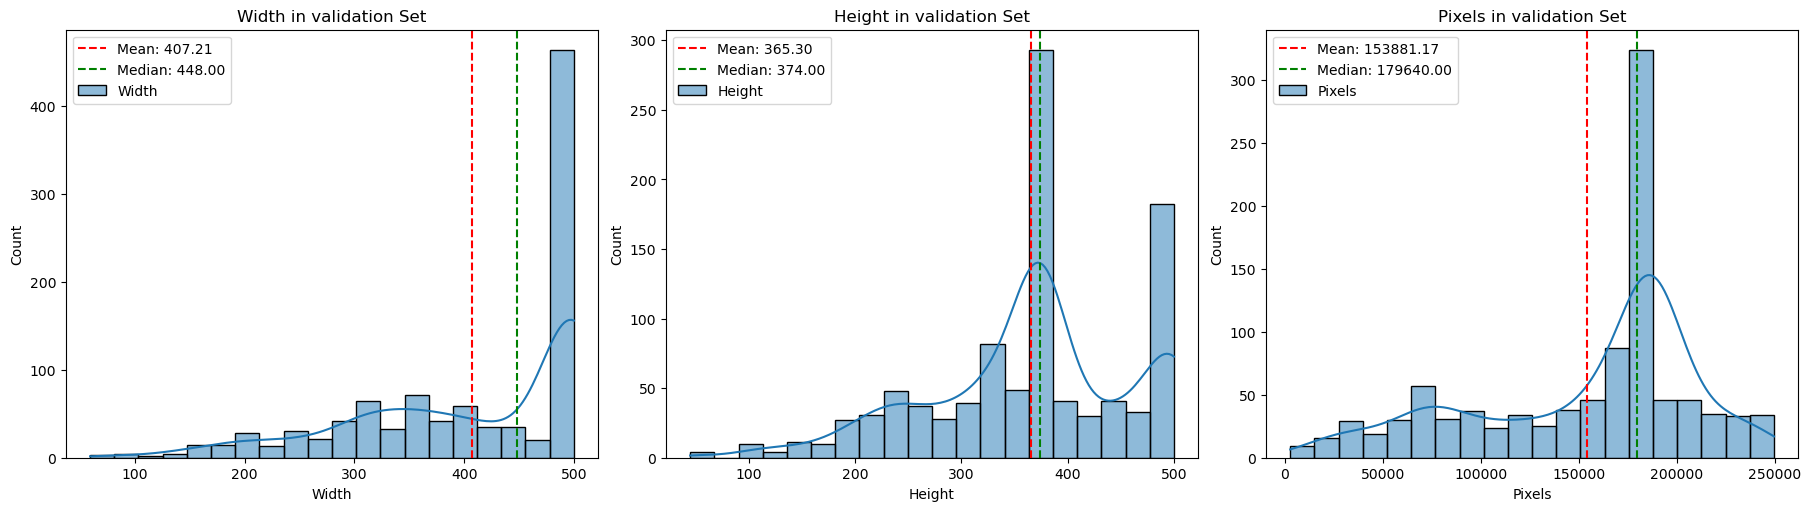

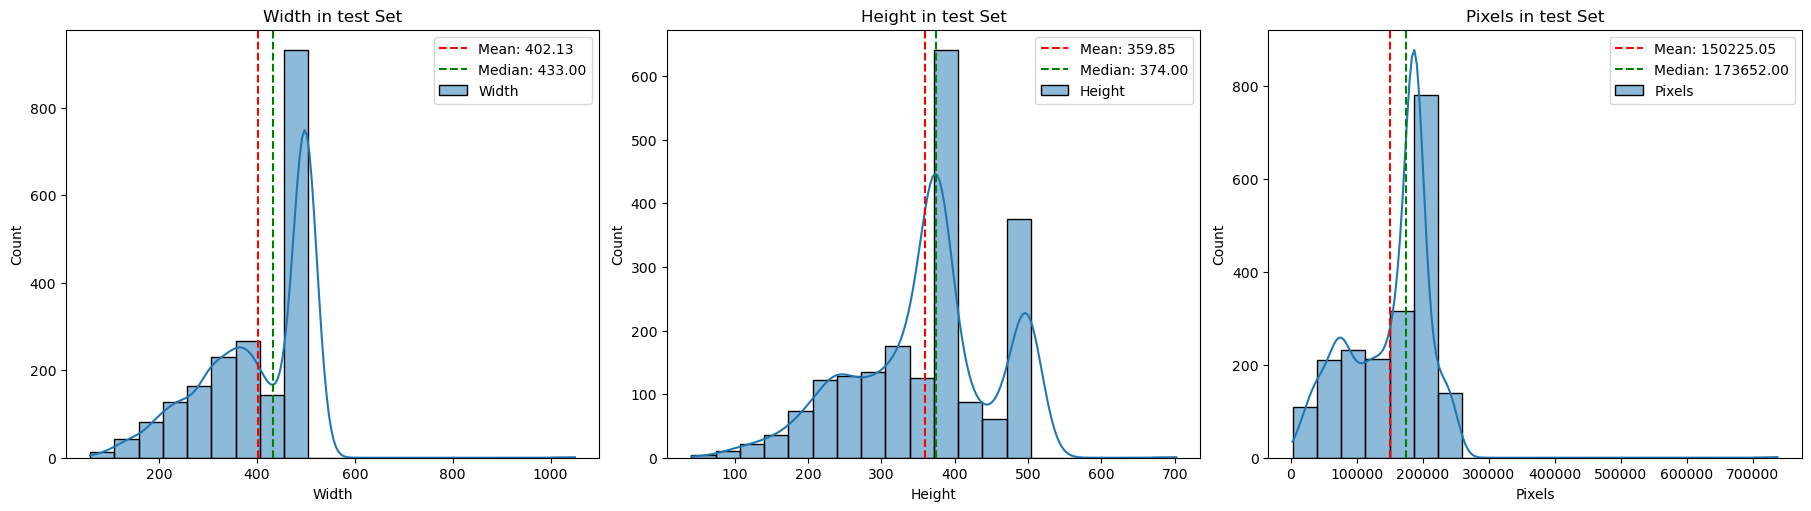

In [5]:
# Plot image dimensions
def plot_image_size_distribution(data_in: pd.DataFrame, type="train"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), layout='constrained')  # 1 row, 3 columns

    # Plot width
    sns.histplot(data=data_in, x="width", bins=20, kde=True, ax=axs[0], label="Width")
    axs[0].set_title(f"Width in {type} Set")
    axs[0].set_xlabel("Width")
    axs[0].set_ylabel("Count")
    axs[0].axvline(data_in.width.mean(), color='red', linestyle='dashed', label=f"Mean: {data_in.width.mean():.2f}")
    axs[0].axvline(data_in.width.median(), color='green', linestyle='dashed', label=f"Median: {data_in.width.median():.2f}")
    axs[0].legend()

    # Plot height
    sns.histplot(data=data_in, x="height", bins=20, kde=True, ax=axs[1], label="Height")
    axs[1].set_title(f"Height in {type} Set")
    axs[1].set_xlabel("Height")
    axs[1].set_ylabel("Count")
    axs[1].axvline(data_in.height.mean(), color='red', linestyle='dashed', label=f"Mean: {data_in.height.mean():.2f}")
    axs[1].axvline(data_in.height.median(), color='green', linestyle='dashed', label=f"Median: {data_in.height.median():.2f}")
    axs[1].legend()

    # Plot pixels (width * height)
    # data_in["pixels"] = data_in["width"] * data_in["height"]
    sns.histplot(data=data_in, x="pixels", bins=20, kde=True, ax=axs[2], label="Pixels")
    axs[2].set_title(f"Pixels in {type} Set")
    axs[2].set_xlabel("Pixels")
    axs[2].set_ylabel("Count")
    axs[2].axvline(data_in.pixels.mean(), color='red', linestyle='dashed', label=f"Mean: {data_in.pixels.mean():.2f}")
    axs[2].axvline(data_in.pixels.median(), color='green', linestyle='dashed', label=f"Median: {data_in.pixels.median():.2f}")
    axs[2].legend()

    plt.show()
    return

plot_image_size_distribution(train_metadata, "train")
plot_image_size_distribution(validation_metadata, "validation")
plot_image_size_distribution(test_metadata, "test")


- Show some samples

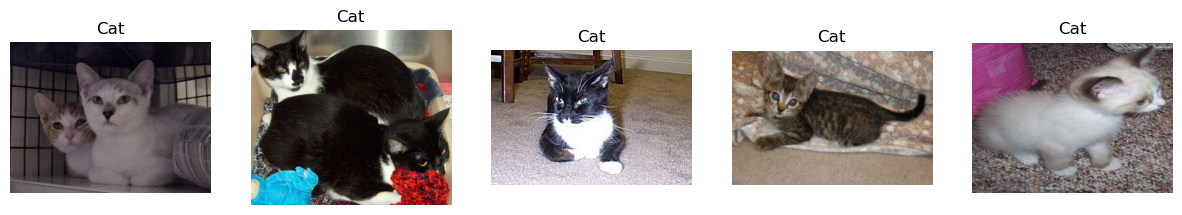

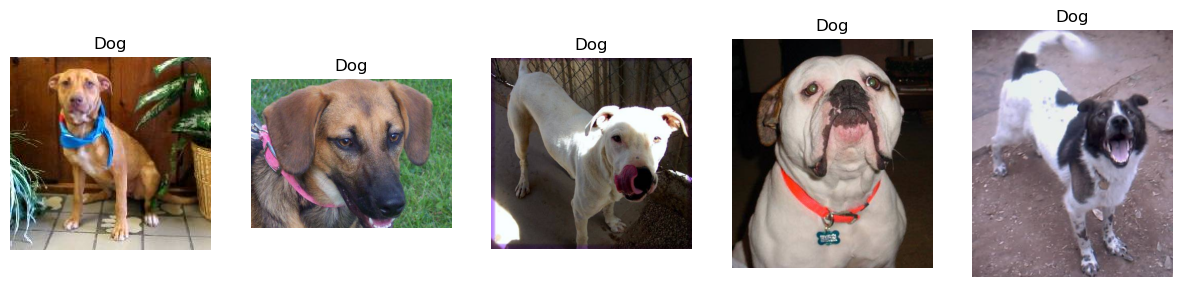

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def show_sample_images(base_dir, subset, category, num_images=5):
    folder = base_dir / subset / category
    images = random.sample(os.listdir(folder), num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"{category.capitalize()}")
        plt.axis('off')
    plt.show()

show_sample_images(new_base_dir, "train", "cat")
show_sample_images(new_base_dir, "train", "dog")

Note: 

## 3. Train two networks (use callbacks to save the best model version)

### 3.1 Define a Neural Network of your choice (3 points)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score

#### Prepare tensorflow dataset

In [8]:
# Set image size and batch size
img_height = 180
img_width = 180
batch_size = 32

# Load training dataset (automatically assigns labels based on subfolder names)
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/kaggle_dogs_vs_cats_small/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary"  # For binary classification
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/kaggle_dogs_vs_cats_small/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary"
)

# Load test dataset (do not shuffle to keep consistent order for evaluation)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/kaggle_dogs_vs_cats_small/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False  # Important for accurate evaluation
)

print(f"class_names:{train_ds.class_names}")

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2025-04-06 17:14:09.970408: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-06 17:14:09.970441: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-06 17:14:09.970446: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1743974049.970459 2163338 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743974049.970482 2163338 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2000 files belonging to 2 classes.
class_names:['cat', 'dog']


#### Check label order: <br>
- label 0 => 'cats'
- label 1 => 'dogs'

In [9]:
print(f"class_names:{train_ds.class_names}")

class_names:['cat', 'dog']


#### Define a simple CNN model

In [ ]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Define a simple CNN model, includes the data augmentation.
inputs = keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
output_path = "output_cnn"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.weights.h5")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=False,
        verbose=1 # Print when model is saved
    )]
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/30


2025-04-06 17:14:47.440270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5049 - loss: 0.7211
Epoch 1: val_loss improved from inf to 0.69166, saving model to output_cnn/best_model.weights.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5050 - loss: 0.7208 - val_accuracy: 0.5330 - val_loss: 0.6917
Epoch 2/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5474 - loss: 0.7124
Epoch 2: val_loss improved from 0.69166 to 0.68443, saving model to output_cnn/best_model.weights.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5469 - loss: 0.7125 - val_accuracy: 0.6200 - val_loss: 0.6844
Epoch 3/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5432 - loss: 0.6968
Epoch 3: val_loss did not improve from 0.68443
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5434 - loss: 0.6967 - val_accuracy: 0.5180 - val_loss: 0.7058
Epoch 4/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5908 - loss: 0.6786
Epoch 4: val_loss did not improve from 0.68443
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5912 - loss: 0.6783 - val_accuracy: 0.5580 - val_loss: 0.7407
Epoch 5/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6080 - loss: 0.6497
Epoch 5: val_loss did not improve from 0.68443
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6085 - loss: 0.6496 - val_accuracy: 0.6020 - val_loss: 0.6911
Epoch 6/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6524 - loss: 0.6351
Epoch 6: val_loss improved from 0.68443 to 0.61635, sav

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6525 - loss: 0.6348 - val_accuracy: 0.6570 - val_loss: 0.6164
Epoch 7/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6984 - loss: 0.5811
Epoch 7: val_loss improved from 0.61635 to 0.58159, saving model to output_cnn/best_model.weights.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6985 - loss: 0.5815 - val_accuracy: 0.6960 - val_loss: 0.5816
Epoch 8/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7260 - loss: 0.5416
Epoch 8: val_loss did not improve from 0.58159
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7261 - loss: 0.5417 - val_accuracy: 0.6640 - val_loss: 0.6051
Epoch 9/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7440 - loss: 0.5229
Epoch 9: val_loss did not improve from 0.58159
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7443 - loss: 0.5225 - val_accuracy: 0.6720 - val_loss: 0.6514
Epoch 10/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7613 - loss: 0.4865
Epoch 10: val_loss improved from 0.58159 to 0.57014, saving model to output_cnn/best_model.weights.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.7612 - loss: 0.4868 - val_accuracy: 0.6880 - val_loss: 0.5701
Epoch 11/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7968 - loss: 0.4359
Epoch 11: val_loss did not improve from 0.57014
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7969 - loss: 0.4358 - val_accuracy: 0.7050 - val_loss: 0.6230
Epoch 12/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8148 - loss: 0.4087
Epoch 12: val_loss did not improve from 0.57014
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8146 - loss: 0.4087 - val_accuracy: 0.6980 - val_loss: 0.6075
Epoch 13/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8268 - loss: 0.3702
Epoch 13: val_loss did not improve from 0.57014
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8272 - loss: 0.3699 - val_accuracy: 0.6730 - val_loss: 0.8030
Epoch 14/30
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8522 - loss: 0.3436
Epoch 14: val_loss did not improve from 0.57014


#### Observe the accuracy and loss during training.

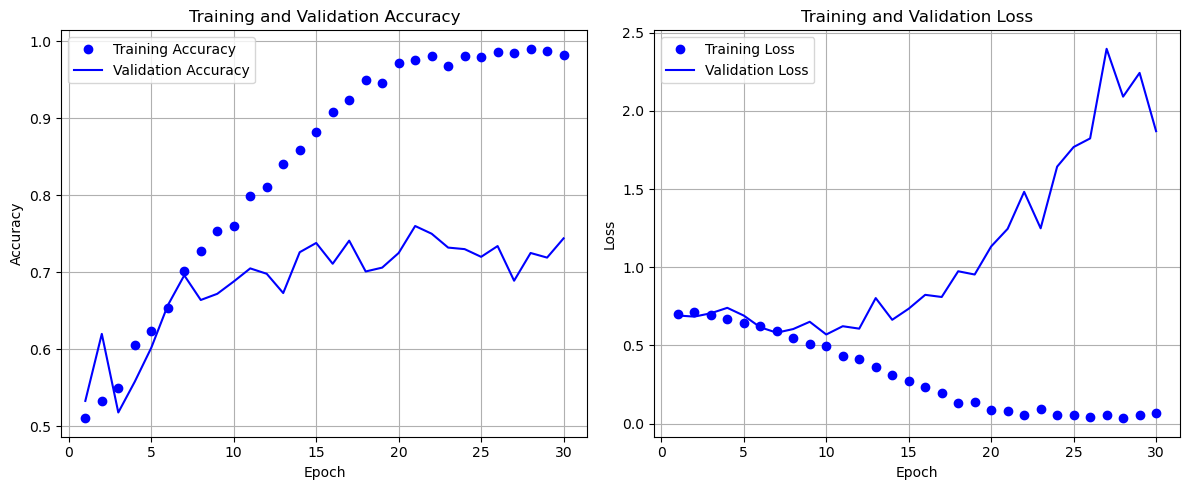

<Figure size 640x480 with 0 Axes>

In [16]:
# Get training history data
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Print per-epoch results
# print("Epoch | Train Acc | Val Acc | Train Loss | Val Loss")
# epoch_step_size = 2
# for i in range(0, len(acc), epoch_step_size):
#     print(f"{i+1:5d} | {acc[i]:9.4f} | {val_acc[i]:7.4f} | {loss[i]:10.4f} | {val_loss[i]:8.4f}")

# Plot accuracy + loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo", label='Training Accuracy')
plt.plot(epochs, val_acc, "b", label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label='Training Loss')
plt.plot(epochs, val_loss, "b", label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_history.png')


#### Evaluate on Testing set

In [15]:
# Evaluate on test data
print(f"Load test model from {model_path}.")
test_model = keras.models.load_model(model_path)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

Load test model from output_cnn/best_model.weights.h5.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7946 - loss: 1.6125
Test accuracy: 0.7460


### 3.2 Define a VGG16 based model (pre-train on imagenet)
Make sure to use validation to test for over-fitting. Plot the appropriate graph (3 points)

#### Download the pretrained model VGG16 as a feature extracter

The cnn_base loaded from VGG16 will be used as a feature encoder (or feature extracter), to help capture the features from the original image.

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 without the top classifier
conv_base = VGG16(
    weights='imagenet', 
    include_top=False)
    # input_shape=(180, 180, 3))

# Freese the pretrained model
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Defne a classifier model included data augmentation and VGG net

In [55]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_vggbased = keras.Model(inputs, outputs)

model_vggbased.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 180, 180,  │          0 │ input_layer_24[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_21         │ (None, 180, 180)  │          0 │ sequential_4[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_22         │ (None, 180, 180)  │          0 │ sequential_4[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_23         │ (None, 180, 180)  │          0 │ sequential_4[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_7 (Stack)     │ (None, 180, 180,  │          0 │ get_item_21[0][0… │
│                     │ 3)                │            │ get_item_22[0][0… │
│                     │                   │            │ get_item_23[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 180, 180,  │          0 │ stack_7[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 12800)     │          0 │ vgg16[2][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │  3,277,056 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │        257 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Compile and train the model (data ugmentation, VGG encoder, classifier)

In [ ]:
model_vggbased.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

output_path = "output_vgg"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor="val_loss")
]
history = model_vggbased.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.9415 - loss: 10.3365 - val_accuracy: 0.9690 - val_loss: 3.9135
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.9659 - loss: 5.0196 - val_accuracy: 0.9770 - val_loss: 3.7580
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.9718 - loss: 3.4085 - val_accuracy: 0.9750 - val_loss: 5.2790
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.9777 - loss: 3.0349 - val_accuracy: 0.9730 - val_loss: 4.9885
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.9689 - loss: 3.7450 - val_accuracy: 0.9770 - val_loss: 3.8487
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.9683 - loss: 4.4402 - val_accuracy: 0.9810 - val_loss: 3.2462
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.9788 - loss: 3.0510 - val_accuracy: 0.9680 - val_loss: 5.4370
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.9681 - loss: 3.9633 - val_acc

#### Plot training history of VGG16 based model

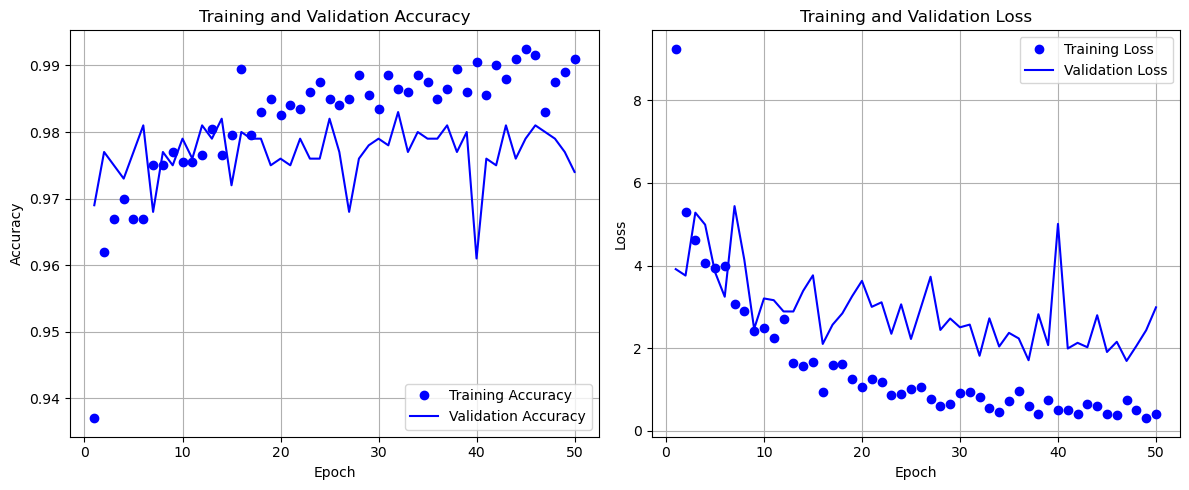

<Figure size 640x480 with 0 Axes>

In [66]:
def plot_training_history(_model, save_file='training_history.png'):
    # Get training history data
    acc = _model.history.history['accuracy']
    val_acc = _model.history.history['val_accuracy']
    loss = _model.history.history['loss']
    val_loss = _model.history.history['val_loss']
    epochs = range(1, len(acc) + 1)


    # Plot accuracy + loss
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo", label='Training Accuracy')
    plt.plot(epochs, val_acc, "b", label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label='Training Loss')
    plt.plot(epochs, val_loss, "b", label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig(save_file)
    return

plot_training_history(_model=model_vggbased)


#### Evaluate on testing set for the VGG16 based model

In [78]:
model_path="./output_vgg/best_model.keras"
print(f"Load test model from {model_path}.")
test_model = keras.models.load_model(model_path)
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

Load test model from ./output_vgg/best_model.keras.
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9821 - loss: 1.3472
Test accuracy: 0.977


### 3.3 Fine-Tune on VGG16 (pre-train on imagenet)
Based on the previous model, but fine-tune some parts of VGG16 network.

Load pretrained VGG16 net but freese some layeres

In [70]:
# Load pre-trained VGG16 without the top classifier
conv_base2 = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(180, 180, 3))

# Freese the pretrained model
conv_base2.trainable = True
for layer in conv_base2.layers[:-4]:
    layer.trainable = False

conv_base2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Define the whole model

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base2(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_vgg_finetune = keras.Model(inputs, outputs)

model_vgg_finetune.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 180, 180,  │          0 │ input_layer_31[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_27         │ (None, 180, 180)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_28         │ (None, 180, 180)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_29         │ (None, 180, 180)  │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_13 (Stack)    │ (None, 180, 180,  │          0 │ get_item_27[0][0… │
│                     │ 3)                │            │ get_item_28[0][0… │
│                     │                   │            │ get_item_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 180, 180,  │          0 │ stack_13[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 12800)     │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │  3,277,056 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │        257 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

#### Compile and finetune the model (data ugmentation, VGG encoder, classifier)

In [72]:
model_vgg_finetune.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

output_path = "output_vgg_finetune"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor="val_loss")
]
history = model_vgg_finetune.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 0.6398 - loss: 5.8508 - val_accuracy: 0.9250 - val_loss: 0.6194
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.8604 - loss: 1.1574 - val_accuracy: 0.9470 - val_loss: 0.3414
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.8980 - loss: 0.6461 - val_accuracy: 0.9480 - val_loss: 0.2250
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.9174 - loss: 0.3579 - val_accuracy: 0.9600 - val_loss: 0.1822
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9404 - loss: 0.2475 - val_accuracy: 0.9610 - val_loss: 0.1513
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9357 - loss: 0.1826 - val_accuracy: 0.9670 - val_loss: 0.1147
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.9455 - loss: 0.2213 - val_accuracy: 0.9630 - val_loss: 0.1211
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9590 - loss: 0.1370 - val_accu

#### Plot training history of VGG16 Finetuned model

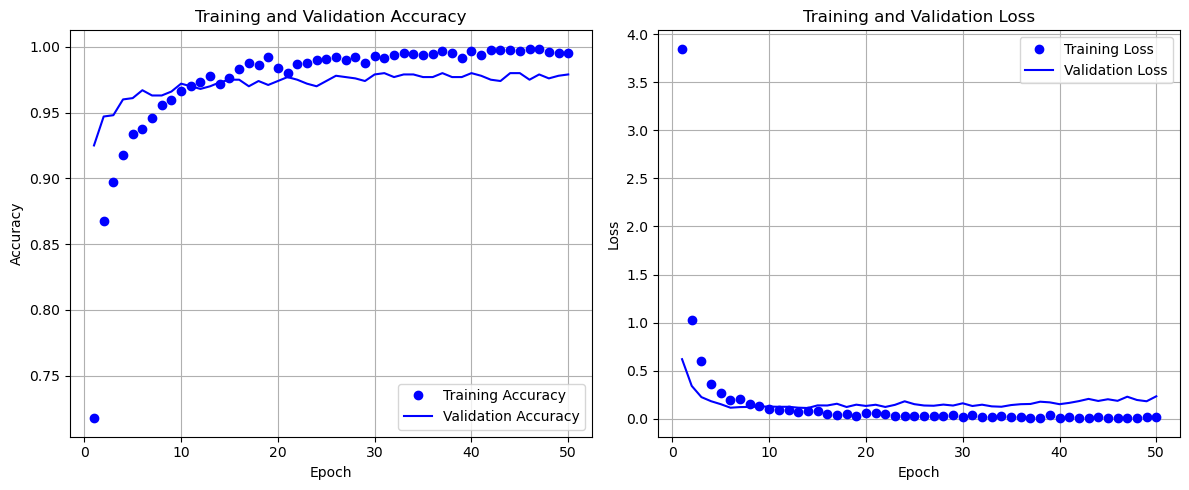

<Figure size 640x480 with 0 Axes>

In [74]:
plot_training_history(_model=model_vgg_finetune)

#### Evaluate on testing set for the VGG16 based model

In [87]:
model_path="./output_vgg_finetune/best_model.keras"
print(f"Load test model from {model_path}.")
test_model = keras.models.load_model(model_path)
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

Load test model from ./output_vgg_finetune/best_model.keras.
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9839 - loss: 0.1118
Test accuracy: 0.979


## 4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points): 
1. accuracy
2. confusion metric
3. precision, recall, F1-score,
4. precision-recall curve.
5. Explore specific examples in which the model failed to predict correctly.

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score

def evaluate_and_observe(model, test_dataset, model_name="Model", threshold=0.5, max_fails=10):
    """
    Evaluate model performance and visualize up to N prediction failures,
    showing both true and predicted labels.
    """
    # Get true and predicted labels
    y_true = np.concatenate([y for _, y in test_dataset])
    y_prob = model.predict(test_dataset)
    y_pred = (y_prob > threshold).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    # Print evaluation results
    print(f"\n{model_name} Evaluation")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_mat)
    print("\nClassification Report:")
    print(report)

    # Plot precision-recall curve
    plt.figure()
    plt.plot(recall, precision, label=model_name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Identify failed predictions
    failures = np.where(y_true != y_pred)[0]
    print(f"\nFailed Predictions for {model_name}")
    print(f"Number of failures: {len(failures)}")

    if len(failures) == 0:
        print("No failures to display.")
        return accuracy, conf_mat, report

    # Collect failure images and labels
    failed_images = []
    failed_true_labels = []
    failed_pred_labels = []

    for i, (image, label) in enumerate(test_dataset.unbatch()):
        if i in failures:
            failed_images.append(image.numpy().astype("uint8"))
            failed_true_labels.append(int(label.numpy()))
            failed_pred_labels.append(int(y_pred[i]))
            if len(failed_images) == max_fails:
                break

    # Plot failed images with true vs predicted labels
    fig, axes = plt.subplots(1, len(failed_images), figsize=(3 * len(failed_images), 3))

    if len(failed_images) == 1:
        axes = [axes]

    for ax, img, true_label, pred_label in zip(axes, failed_images, failed_true_labels, failed_pred_labels):
        ax.imshow(img)
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return accuracy, conf_mat, report


Evaluate on Testing set (Simple CNN model)

Load test model from output_cnn/best_model.weights.h5.
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step

CNN Evaluation
Accuracy: 69.50%
Confusion Matrix:
[[654 346]
 [264 736]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.65      0.68      1000
         1.0       0.68      0.74      0.71      1000

    accuracy                           0.69      2000
   macro avg       0.70      0.70      0.69      2000
weighted avg       0.70      0.69      0.69      2000



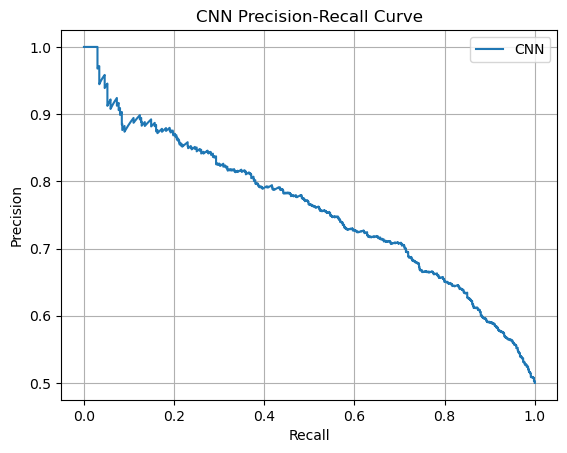


Failed Predictions for CNN
Number of failures: 610


/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_true_labels.append(int(label.numpy()))
/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_pred_labels.append(int(y_pred[i]))


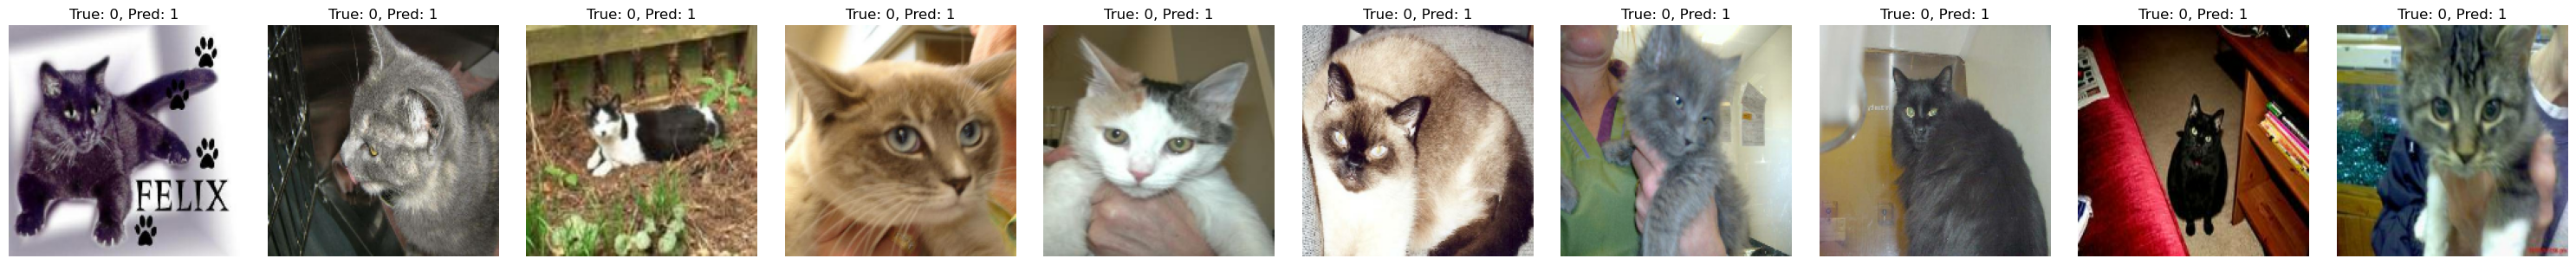

In [ ]:
# Load CNN model
output_path = "output_cnn"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.weights.h5")
print(f"Load test model from {model_path}.")
test_model_cnn = keras.models.load_model(model_path)

# Evaluate on test data
cnn_results = evaluate_and_observe(test_model_cnn, test_ds, model_name="CNN")

Evaluate on testing set for the VGG16 based model

Load test model from output_vgg/best_model.keras.
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step

VGG16 Evaluation
Accuracy: 97.70%
Confusion Matrix:
[[982  18]
 [ 28 972]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1000
         1.0       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



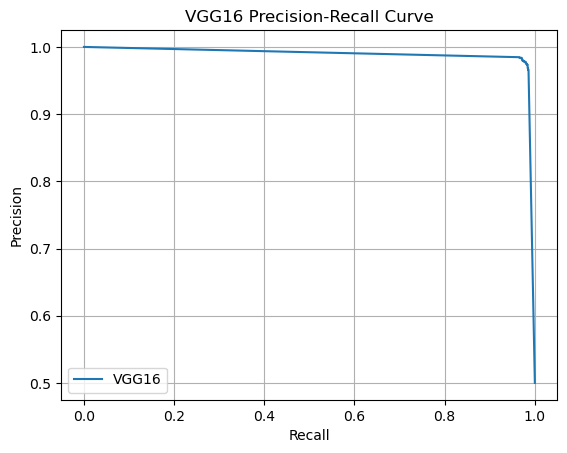


Failed Predictions for VGG16
Number of failures: 46


/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_true_labels.append(int(label.numpy()))
/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_pred_labels.append(int(y_pred[i]))


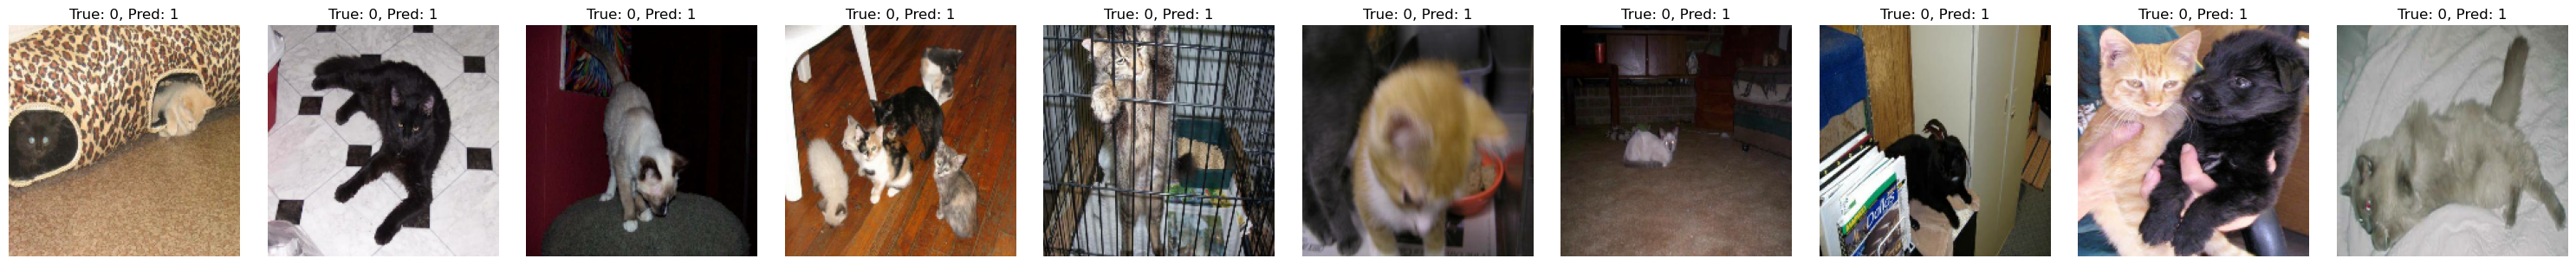

In [ ]:
# Load VGG16 pretrained model
output_path = "output_vgg"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.keras")
print(f"Load test model from {model_path}.")ＣＮＮ：1.
test_model_vgg16 = keras.models.load_model(model_path)

# Evaluate on test data
vgg16_results = evaluate_and_observe(test_model_vgg16, test_ds, model_name="VGG16")

Load test model from output_vgg_finetune/best_model.keras.
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step

VGG16_finetune Evaluation
Accuracy: 97.90%
Confusion Matrix:
[[985  15]
 [ 27 973]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1000
         1.0       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



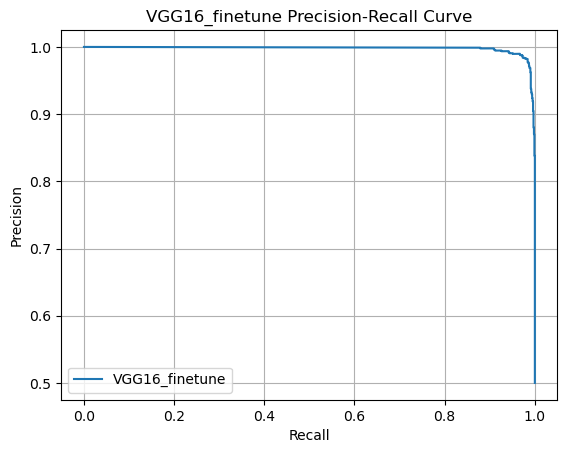


Failed Predictions for VGG16_finetune
Number of failures: 42


/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_true_labels.append(int(label.numpy()))
/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_9281/3663793153.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  failed_pred_labels.append(int(y_pred[i]))


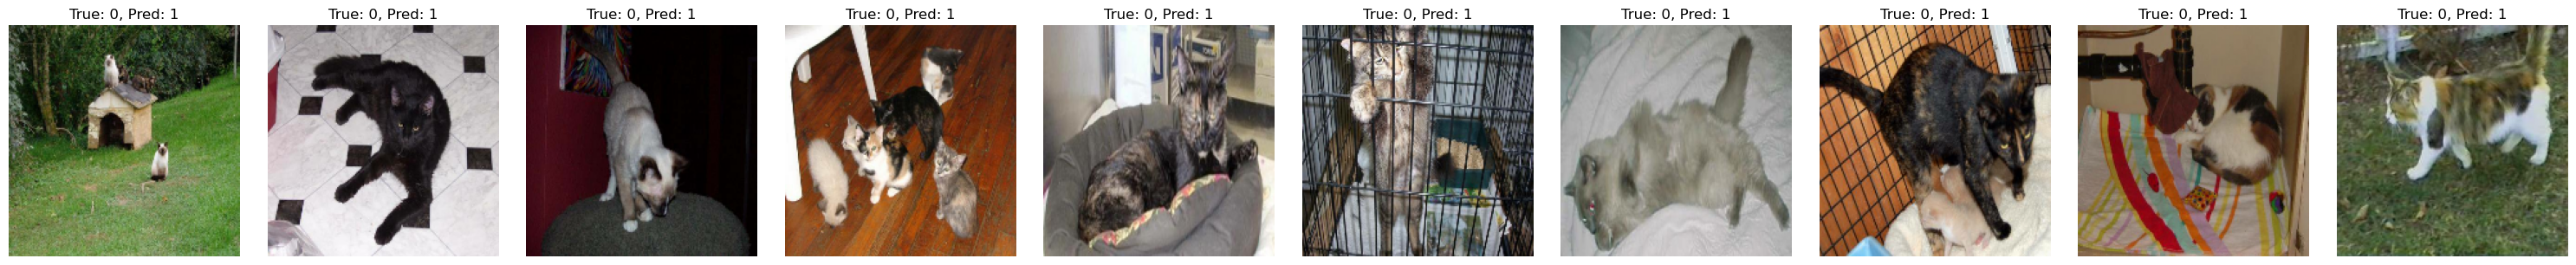

In [ ]:
# Load VGG16 finetuned model
output_path = "output_vgg_finetune"
os.makedirs(output_path, exist_ok=True)
model_path = os.path.join(output_path, "best_model.keras")
print(f"Load test model from {model_path}.")
test_model_vgg16_finetune = keras.models.load_model(model_path)

# Evaluate on test data
vgg16_finetune_results = evaluate_and_observe(test_model_vgg16_finetune, test_ds, model_name="VGG16_finetune")

## 5. Add your conclusions. (3 point)

**The simple CNN model**: The baseline CNN model achieved an accuracy of 69.5%, with a relatively balanced performance between precision and recall. However, the confusion matrix shows a significant number of misclassifications (346 false positives and 264 false negatives), indicating limited ability in distinguishing between the two classes. The precision-recall curve drops steadily, showing that this model struggles with precision as recall increases.

**VGG16 pretrained model**: The VGG16 model, using a frozen convolutional base with custom classification layers on top, achieved 97.7% accuracy. The confusion matrix indicates only a few errors (18 false positives and 28 false negatives), showing strong class discrimination. The precision-recall curve is nearly perfect, maintaining high precision across all recall levels.

**VGG16 finetuned model**: The finetuned VGG16 model achieved the highest accuracy at 97.9%. By unfreezing and fine-tuning part of the convolutional base, it slightly improved upon the already strong performance of the frozen VGG16. The number of incorrect predictions is further reduced (15 false positives and 27 false negatives). Its precision-recall curve is also excellent, suggesting near-optimal classification performance.